# Finetuning with PyTorch


Resources:
- https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

What's finetuning ?

Which tasks ?


What is CIFAR-10?

https://en.wikipedia.org/wiki/CIFAR-10

The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class

In [ ]:

# Todo:
- Explain optimizer 
- Explain gradient zero + gradient step
- Show training loss + validation loss 
- confusion matrix


Now let's unzip it

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

import numpy as np

In [2]:
device_str = "cpu"
if torch.cuda.is_available():
    device_str = "cuda:0"
elif torch.backends.mps.is_available():
    device_str = "mps"
device = torch.device(device_str)
device

device(type='cuda', index=0)

In [3]:
data_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0) == 1 else x),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.Resize(size=224, max_size=225),
        transforms.CenterCrop((224, 224)),
    ]
)

full_dataset = torchvision.datasets.Caltech101(
    root="./data/Caltech101",
    target_type="category",
    # target_type="annotation",
    download=True,
    transform=data_transform,
)

# Split the dataset into train and test sets
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Files already downloaded and verified
Train dataset size: 6941
Test dataset size: 1736


In [4]:
batch_size = 4

train_loader = torch.utils.data.DataLoader(
    train_dataset, 
	batch_size=batch_size, 
	shuffle=True, 
	num_workers=2,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, 
	batch_size=batch_size, 
	shuffle=False, 
	num_workers=2,
)

classes = full_dataset.categories
classes

['Faces',
 'Faces_easy',
 'Leopards',
 'Motorbikes',
 'accordion',
 'airplanes',
 'anchor',
 'ant',
 'barrel',
 'bass',
 'beaver',
 'binocular',
 'bonsai',
 'brain',
 'brontosaurus',
 'buddha',
 'butterfly',
 'camera',
 'cannon',
 'car_side',
 'ceiling_fan',
 'cellphone',
 'chair',
 'chandelier',
 'cougar_body',
 'cougar_face',
 'crab',
 'crayfish',
 'crocodile',
 'crocodile_head',
 'cup',
 'dalmatian',
 'dollar_bill',
 'dolphin',
 'dragonfly',
 'electric_guitar',
 'elephant',
 'emu',
 'euphonium',
 'ewer',
 'ferry',
 'flamingo',
 'flamingo_head',
 'garfield',
 'gerenuk',
 'gramophone',
 'grand_piano',
 'hawksbill',
 'headphone',
 'hedgehog',
 'helicopter',
 'ibis',
 'inline_skate',
 'joshua_tree',
 'kangaroo',
 'ketch',
 'lamp',
 'laptop',
 'llama',
 'lobster',
 'lotus',
 'mandolin',
 'mayfly',
 'menorah',
 'metronome',
 'minaret',
 'nautilus',
 'octopus',
 'okapi',
 'pagoda',
 'panda',
 'pigeon',
 'pizza',
 'platypus',
 'pyramid',
 'revolver',
 'rhino',
 'rooster',
 'saxophone',
 'sc

In [5]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(f"{images.shape = }")
print(f"{labels = }")

images.shape = torch.Size([4, 3, 224, 224])
labels = tensor([72, 75, 87,  0])


images.shape = torch.Size([4, 3, 224, 224])
labels = tensor([23, 57, 32, 32])


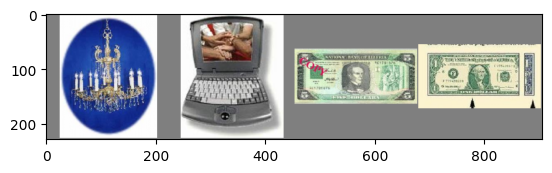

chandelier laptop     dollar_bill dollar_bill


In [6]:


# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(f"{images.shape = }")
print(f"{labels = }")

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:10s}' for j in range(batch_size)))

# Define a Convolutional Neural Network

In [7]:



class Net(nn.Module):
    def __init__(self, nb_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((5, 5))  # Add adaptive pooling layer
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, nb_classes)

    def forward(self, x):
        # print(f"Input: {x.shape = }")	
        x = self.pool(F.relu(self.conv1(x)))
        # print(f"After conv1 and pool: {x.shape = }")
        x = self.pool(F.relu(self.conv2(x)))
        # print(f"After conv2 and pool: {x.shape = }")
        x = self.adaptive_pool(x)  # Apply adaptive pooling
        # print(f"After adaptive pool: {x.shape = }")
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        # print(f"After flatten: {x.shape = }")
        x = F.relu(self.fc1(x))
        # print(f"After fc1: {x.shape = }")
        x = F.relu(self.fc2(x))
        # print(f"After fc2: {x.shape = }")
        x = self.fc3(x)
        # print(f"Output: {x.shape = }")
        return x

# Define a Loss function and optimizer

# Train

In [12]:
def train(net, train_loader, criterion, optimizer, device, epochs=2):
    print_every_n_batch = (len(train_loader) / batch_size) // 10
    if print_every_n_batch == 0:
        print_every_n_batch = 1
    net.to(device)
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(train_loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # Move inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            # print(f"Inputs: {inputs.shape = }", flush=True)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % print_every_n_batch == 0 and i:
                print(
                    f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_every_n_batch:.3f}"
                )
                running_loss = 0.0

    print("Finished Training")


def evaluate_model(net, test_loader, device):
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_loader:
            images, labels = data

            images = images.to(device)
            labels = labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total

    # Compute precision, recall, and f1-score for each class
    from sklearn.metrics import precision_recall_fscore_support

    precision, recall, f1score, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average="weighted"
    )

    print(f"Accuracy of the network on the {total} test images: {accuracy:.2f}%")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1-score: {f1score:.4f}")

    return accuracy, precision, recall, f1score

In [9]:
model_path = "./data/caltech_baseline_net.pth"

model = Net(nb_classes=len(classes))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

if True:
    train(model, train_loader, criterion, optimizer, device, epochs=10)
    torch.save(model.state_dict(), model_path)
else:
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.to(device)
evaluate_model(model, test_loader, device)

/home/ezalos/42/Notebooks2Teach/venv/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


[1,    44] loss: 4.722
[1,    87] loss: 4.599
[1,   130] loss: 4.606
[1,   173] loss: 4.569
[1,   216] loss: 4.595
[1,   259] loss: 4.555
[1,   302] loss: 4.548
[1,   345] loss: 4.513
[1,   388] loss: 4.508
[1,   431] loss: 4.530
[1,   474] loss: 4.454
[1,   517] loss: 4.385
[1,   560] loss: 4.410
[1,   603] loss: 4.258
[1,   646] loss: 4.318
[1,   689] loss: 4.204
[1,   732] loss: 4.243
[1,   775] loss: 4.134
[1,   818] loss: 4.030
[1,   861] loss: 4.142
[1,   904] loss: 4.137
[1,   947] loss: 4.030
[1,   990] loss: 3.923
[1,  1033] loss: 4.095
[1,  1076] loss: 3.680
[1,  1119] loss: 3.798
[1,  1162] loss: 4.025
[1,  1205] loss: 3.663
[1,  1248] loss: 3.730
[1,  1291] loss: 3.568
[1,  1334] loss: 3.557
[1,  1377] loss: 3.561
[1,  1420] loss: 3.747
[1,  1463] loss: 3.540
[1,  1506] loss: 3.480
[1,  1549] loss: 3.562
[1,  1592] loss: 3.529
[1,  1635] loss: 3.476
[1,  1678] loss: 3.589
[1,  1721] loss: 3.536
[2,    44] loss: 3.347
[2,    87] loss: 3.471
[2,   130] loss: 3.212
[2,   173] 

/home/ezalos/42/Notebooks2Teach/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(46.31336405529954,
 0.46855596491869667,
 0.4631336405529954,
 0.4413219699519816)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


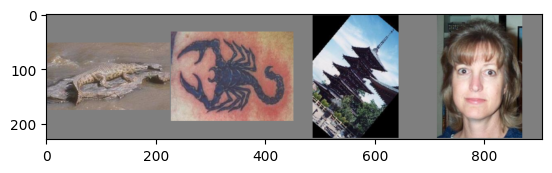

GroundTruth:
 crocodile  scorpion   pagoda     Faces_easy


In [10]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print("GroundTruth:\n", " ".join(f"{classes[labels[j]]:10s}" for j in range(4)))

In [11]:
net = Net(nb_classes=len(classes))
net.load_state_dict(torch.load(model_path, weights_only=True))
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(5, 5))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=101, bias=True)
)

In [12]:
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print("Predicted: ", " ".join(f"{classes[predicted[j]]:5s}" for j in range(4)))

Predicted:  airplanes watch pagoda Faces_easy


In [13]:

# Call the function
accuracy, precision, recall, f1score = evaluate_model(net, test_loader, device)

Accuracy of the network on the 1736 test images: 46.31%
Weighted Precision: 0.4686
Weighted Recall: 0.4631
Weighted F1-score: 0.4413


/home/ezalos/42/Notebooks2Teach/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
def evaluate_class_accuracy(net, test_loader, device, classes):
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f"Accuracy for class: {classname:5s} is {accuracy:.1f} %")

# evaluate_class_accuracy(net, test_loader, device, classes)

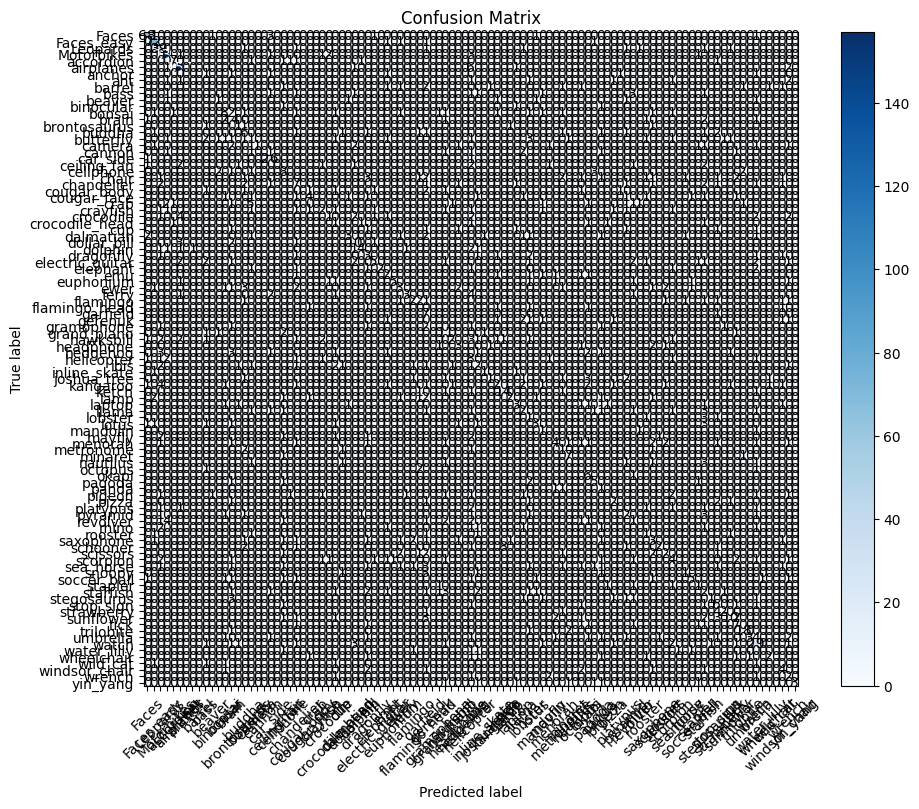

In [15]:
# Make a confusion matrix

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(net, test_loader, device, classes):
    # Initialize confusion matrix
    conf_matrix = np.zeros((len(classes), len(classes)), dtype=int)

    # Compute confusion matrix
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            for t, p in zip(labels.view(-1), predicted.view(-1)):
                conf_matrix[t.long(), p.long()] += 1

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Add text annotations
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(net, test_loader, device, classes)


In [16]:
class EfficientNetB0(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.efficientnet_b0 = torchvision.models.efficientnet_b0(weights="DEFAULT")
        self.efficientnet_b0.classifier[1] = nn.Linear(
            self.efficientnet_b0.classifier[1].in_features, n_classes
        )

    def forward(self, x):
        return F.log_softmax(self.efficientnet_b0(x), dim=1)

efficientnet = EfficientNetB0(n_classes=len(classes))
efficientnet

EfficientNetB0(
  (efficientnet_b0): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
           

In [17]:
criterion = nn.CrossEntropyLoss()
params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

for name, param in efficientnet.named_parameters():
    # print(name)
    if name.startswith("efficientnet_b0.classifier"):
        param.requires_grad = True
        params_to_update_1.append(param)
    elif name.startswith("efficientnet_b0.features.8"):
        param.requires_grad = True
        params_to_update_2.append(param)
    elif name.startswith("efficientnet_b0.features"):
        param.requires_grad = True
        params_to_update_3.append(param)
    else:
        param.requires_grad = False

print(f"{len(params_to_update_1) = }")
print(f"{len(params_to_update_2) = }")
print(f"{len(params_to_update_3) = }")

optimizer = torch.optim.SGD(
    [
        {"params": params_to_update_1, "lr": 1e-3},
        {"params": params_to_update_2, "lr": 5e-4},
        {"params": params_to_update_3, "lr": 1e-4},
    ],
    momentum=0.9,
)

len(params_to_update_1) = 2
len(params_to_update_2) = 3
len(params_to_update_3) = 208


In [18]:
model_path = "./data/caltech_finetuned_efficient_net.pth"
model = efficientnet
NB_EPOCHS = 3

if True:
    train(model, train_loader, criterion, optimizer, device, epochs=NB_EPOCHS)
    torch.save(model.state_dict(), model_path)
else:
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.to(device)
evaluate_model(model, test_loader, device)

[1,    44] loss: 4.604
[1,    87] loss: 4.257
[1,   130] loss: 3.960
[1,   173] loss: 3.796
[1,   216] loss: 3.700
[1,   259] loss: 3.542
[1,   302] loss: 3.490
[1,   345] loss: 3.577
[1,   388] loss: 3.320
[1,   431] loss: 3.168
[1,   474] loss: 3.163
[1,   517] loss: 3.201
[1,   560] loss: 3.152
[1,   603] loss: 2.869
[1,   646] loss: 2.931
[1,   689] loss: 2.989
[1,   732] loss: 2.941
[1,   775] loss: 2.929
[1,   818] loss: 2.642
[1,   861] loss: 2.882
[1,   904] loss: 2.724
[1,   947] loss: 2.480
[1,   990] loss: 2.798
[1,  1033] loss: 2.799
[1,  1076] loss: 2.847
[1,  1119] loss: 2.678
[1,  1162] loss: 2.514
[1,  1205] loss: 2.426
[1,  1248] loss: 2.587
[1,  1291] loss: 2.658
[1,  1334] loss: 2.736
[1,  1377] loss: 2.555
[1,  1420] loss: 2.381
[1,  1463] loss: 2.505
[1,  1506] loss: 2.497
[1,  1549] loss: 2.645
[1,  1592] loss: 2.389
[1,  1635] loss: 2.413
[1,  1678] loss: 2.240
[1,  1721] loss: 2.139
[2,    44] loss: 2.096
[2,    87] loss: 2.057
[2,   130] loss: 1.931
[2,   173] 

(89.86175115207374, 0.902717609906525, 0.8986175115207373, 0.8965447865320184)

In [19]:
def get_pretrained_net():
    resnet = torchvision.models.resnet18(pretrained=True)
    resnet.train()

    resnet.fc = torch.nn.Linear(resnet.fc.in_features, len(classes))
    torch.nn.init.xavier_uniform_(resnet.fc.weight)

    return resnet

pretrained_net = get_pretrained_net()
pretrained_net

/home/ezalos/42/Notebooks2Teach/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ezalos/42/Notebooks2Teach/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
criterion = nn.CrossEntropyLoss()
params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

for name, param in pretrained_net.named_parameters():
    if name.startswith("fc"):
        param.requires_grad = True
        params_to_update_1.append(param)
    elif name.startswith("layer4"):
        param.requires_grad = True
        params_to_update_2.append(param)
    elif name.startswith("layer"):
        param.requires_grad = True
        params_to_update_3.append(param)
    else:
        param.requires_grad = False

optimizer = torch.optim.SGD(
    [
		{'params': params_to_update_1, 'lr': 1e-3},
		{'params': params_to_update_2, 'lr': 5e-4},
		{'params': params_to_update_3, 'lr': 1e-4},
	],
    momentum=0.9,
)

In [21]:
model_path = "./data/caltech_finetuned_resnet18.pth"
model = pretrained_net
NB_EPOCHS = 3

if True:
    train(model, train_loader, criterion, optimizer, device, epochs=NB_EPOCHS)
    torch.save(model.state_dict(), model_path)
else:
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.to(device)
    
evaluate_model(model, test_loader, device)

[1,    44] loss: 4.653
[1,    87] loss: 3.833
[1,   130] loss: 3.540
[1,   173] loss: 2.971
[1,   216] loss: 2.400
[1,   259] loss: 2.310
[1,   302] loss: 2.061
[1,   345] loss: 2.261
[1,   388] loss: 1.858
[1,   431] loss: 2.027
[1,   474] loss: 1.699
[1,   517] loss: 1.515
[1,   560] loss: 1.756
[1,   603] loss: 1.605
[1,   646] loss: 1.381
[1,   689] loss: 1.288
[1,   732] loss: 1.166
[1,   775] loss: 1.353
[1,   818] loss: 1.147
[1,   861] loss: 1.230
[1,   904] loss: 1.140
[1,   947] loss: 0.910
[1,   990] loss: 0.822
[1,  1033] loss: 0.886
[1,  1076] loss: 1.112
[1,  1119] loss: 1.043
[1,  1162] loss: 0.957
[1,  1205] loss: 0.830
[1,  1248] loss: 0.951
[1,  1291] loss: 0.947
[1,  1334] loss: 0.843
[1,  1377] loss: 0.851
[1,  1420] loss: 0.807
[1,  1463] loss: 0.885
[1,  1506] loss: 0.742
[1,  1549] loss: 0.639
[1,  1592] loss: 0.603
[1,  1635] loss: 0.696
[1,  1678] loss: 0.643
[1,  1721] loss: 0.705
[2,    44] loss: 0.550
[2,    87] loss: 0.418
[2,   130] loss: 0.443
[2,   173] 

(94.29723502304148, 0.9482147931708914, 0.9429723502304147, 0.9416053088679074)

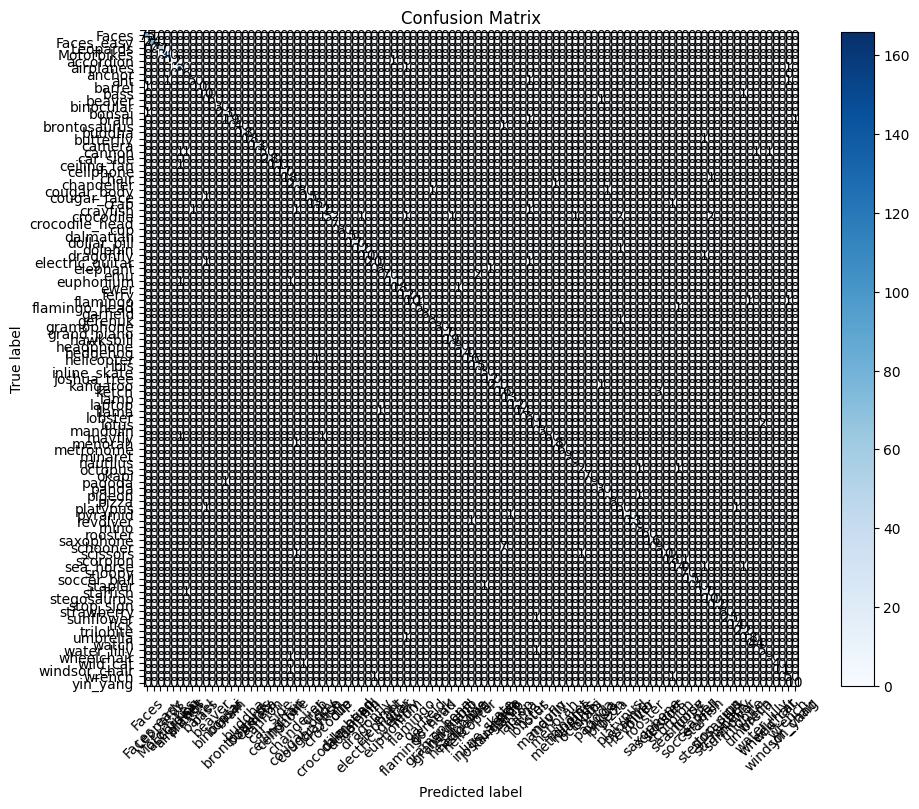

In [22]:
plot_confusion_matrix(pretrained_net, test_loader, device, classes)

In [7]:
mobile_net = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
mobile_net.train()
mobile_net.classifier[1] = torch.nn.Linear(mobile_net.classifier[1].in_features, len(classes))
torch.nn.init.xavier_uniform_(mobile_net.classifier[1].weight)
mobile_net

Using cache found in /home/ezalos/.cache/torch/hub/pytorch_vision_v0.10.0
/home/ezalos/42/Notebooks2Teach/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ezalos/42/Notebooks2Teach/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [10]:
criterion = nn.CrossEntropyLoss()
params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

for name, param in mobile_net.named_parameters():
    if name.startswith("classifier"):
        param.requires_grad = True
        params_to_update_1.append(param)
    # elif name.startswith("features"):
    #     param.requires_grad = True
    #     params_to_update_2.append(param)
    elif name.startswith("features"):
        param.requires_grad = True
        params_to_update_3.append(param)
    else:
        param.requires_grad = False

print(f"{len(params_to_update_1) = }")
print(f"{len(params_to_update_2) = }")
print(f"{len(params_to_update_3) = }")

optimizer = torch.optim.SGD(
    [
        {"params": params_to_update_1, "lr": 1e-3},
        {"params": params_to_update_2, "lr": 5e-4},
        {"params": params_to_update_3, "lr": 1e-4},
    ],
    momentum=0.9,
)

len(params_to_update_1) = 2
len(params_to_update_2) = 0
len(params_to_update_3) = 156


In [13]:
model_path = "./data/caltech_finetuned_mobile_net.pth"
model = mobile_net
NB_EPOCHS = 3

if True:
    train(model, train_loader, criterion, optimizer, device, epochs=NB_EPOCHS)
    torch.save(model.state_dict(), model_path)
else:
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.to(device)
evaluate_model(model, test_loader, device)

[1,    44] loss: 4.683
[1,    87] loss: 3.977
[1,   130] loss: 3.625
[1,   173] loss: 3.322
[1,   216] loss: 3.053
[1,   259] loss: 2.916
[1,   302] loss: 2.906
[1,   345] loss: 2.731
[1,   388] loss: 2.461
[1,   431] loss: 2.552
[1,   474] loss: 2.459
[1,   517] loss: 2.258
[1,   560] loss: 2.225
[1,   603] loss: 2.121
[1,   646] loss: 2.007
[1,   689] loss: 2.020
[1,   732] loss: 1.861
[1,   775] loss: 1.831
[1,   818] loss: 1.979
[1,   861] loss: 1.908
[1,   904] loss: 1.945
[1,   947] loss: 1.699
[1,   990] loss: 1.617
[1,  1033] loss: 1.651
[1,  1076] loss: 1.742
[1,  1119] loss: 1.511
[1,  1162] loss: 1.451
[1,  1205] loss: 1.283
[1,  1248] loss: 1.273
[1,  1291] loss: 1.379
[1,  1334] loss: 1.478
[1,  1377] loss: 1.255
[1,  1420] loss: 1.170
[1,  1463] loss: 1.318
[1,  1506] loss: 1.306
[1,  1549] loss: 1.080
[1,  1592] loss: 0.944
[1,  1635] loss: 1.246
[1,  1678] loss: 0.874
[1,  1721] loss: 1.135
[2,    44] loss: 0.974
[2,    87] loss: 0.787
[2,   130] loss: 0.753
[2,   173] 

(92.05069124423963, 0.9256615131584512, 0.9205069124423964, 0.9190751071904016)

In [ ]:
plot_confusion_matrix(net, test_loader, device, classes)